In [ ]:
!gdown 1wXqPYvIEjbH1rmFSkgVAPe3OjZ3TzC3E
!gdown 1C-2oilDOXKBa5MU3DL_oCzCvNP-BTAwB
!gdown 1g2kjOA3trwLKn4ApdqyAMn8Y5QLo9ZLX

Downloading...
From: https://drive.google.com/uc?id=1wXqPYvIEjbH1rmFSkgVAPe3OjZ3TzC3E
To: /home/aivn48/Downloads/aa/Khoa_deploy/final_05Mar2024/content_img.jpg
100%|██████████████████████████████████████| 83.3k/83.3k [00:00<00:00, 1.45MB/s]
Downloading...
From: https://drive.google.com/uc?id=1C-2oilDOXKBa5MU3DL_oCzCvNP-BTAwB
To: /home/aivn48/Downloads/aa/Khoa_deploy/final_05Mar2024/style_img.jpg
100%|████████████████████████████████████████| 195k/195k [00:00<00:00, 2.05MB/s]
Downloading...
From: https://drive.google.com/uc?id=1g2kjOA3trwLKn4ApdqyAMn8Y5QLo9ZLX
To: /home/aivn48/Downloads/aa/Khoa_deploy/final_05Mar2024/style_img2.jpg
100%|████████████████████████████████████████| 227k/227k [00:00<00:00, 2.36MB/s]


## 1. Imports

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import torch
import torch.nn as nn

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 2. Data

In [ ]:
from PIL import Image
import torchvision.transforms as transforms

imsize = 256

img_transforms = transforms.Compose([
    transforms.Resize((imsize, imsize)),
    transforms.ToTensor(),
])


In [ ]:
def image_loader(image_name):
    image = Image.open(image_name)
    image = img_transforms(image).unsqueeze(0)
    return image.to(device, torch.float)

style_img1 = image_loader("style_img.jpg")
style_img2 = image_loader("style_img2.jpg")
content_img = image_loader("content_img.jpg")

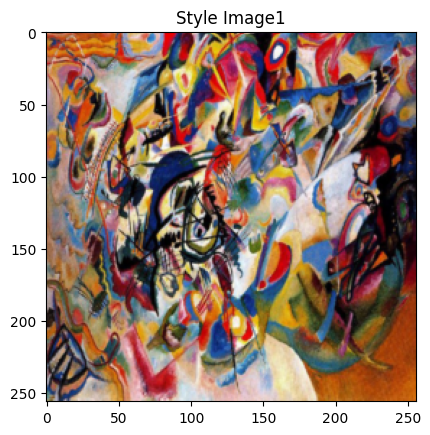

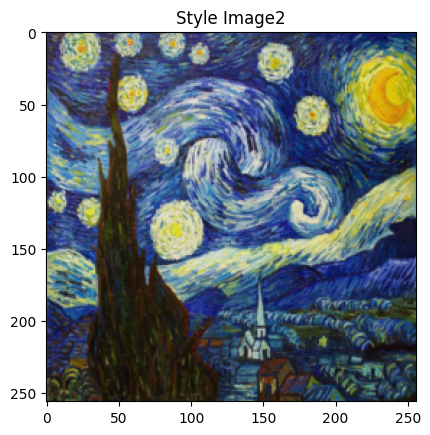

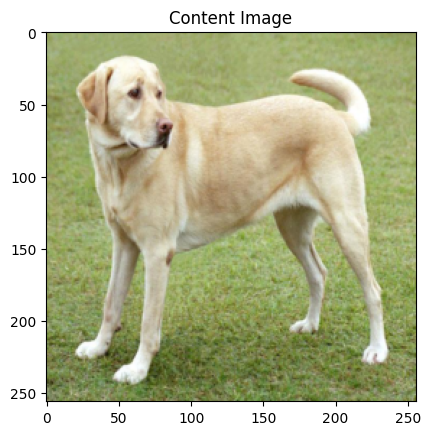

In [ ]:
unloader = transforms.ToPILImage()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


plt.figure()
imshow(style_img1, title='Style Image1')

plt.figure()
imshow(style_img2, title='Style Image2')

plt.figure()
imshow(content_img, title='Content Image')

## 3. Loss Functions

### 3.1 Content Loss

In [ ]:
content_weight = 1
ContentLoss = nn.MSELoss()

### 3.2 Style Loss

In [ ]:
def gram_matrix(tensor):
    a, b, c, d = tensor.size()
    tensor = tensor.view(a * b, c * d)
    G = torch.mm(tensor, tensor.t())
    return G.div(a * b * c * d)

style_weight = 1e6
StyleLoss = nn.MSELoss()

## 3. Model

In [ ]:
from torchvision.models import vgg19, VGG19_Weights

VGG19_pretrained = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()
VGG19_pretrained.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [ ]:
content_layers = ['conv_4']
style_layers = ['conv_1', 'conv_2',
                'conv_3', 'conv_4',
                'conv_5']

In [ ]:
def get_features(pretrained_model, image):
    layers = {
        '0': 'conv_1',
        '5': 'conv_2',
        '10': 'conv_3',
        '19': 'conv_4',
        '28': 'conv_5'
    }
    features = {}
    x = image
    for name, pretrained_layer in pretrained_model._modules.items():
        x = pretrained_layer(x)
        if name in layers:
            features[layers[name]] = x
    return features


In [ ]:
def get_dual_style(style_features1, style_features2, style_layers):
    final_style_features = {}
    for layer in style_layers:
        sf1 = style_features1[layer]
        sf2 = style_features2[layer]
        sf1_size = int(sf1.size()[1] / 4)
        final_style_features[layer] = torch.concatenate([
                                        sf1[:,:sf1_size,:,:],
                                        sf2[:,sf1_size:,:,:]
                                    ], dim=1)
    return final_style_features

In [ ]:
content_features = get_features(VGG19_pretrained, content_img)
style_features1 = get_features(VGG19_pretrained, style_img1)
style_features2 = get_features(VGG19_pretrained, style_img2)
final_style_features = get_dual_style(style_features1, style_features2, style_layers)

## 4. Training

In [ ]:
import torch.optim as optim

target_img = content_img.clone().requires_grad_(True).to(device)
optimizer = optim.Adam([target_img], lr=0.02)


In [ ]:
def style_tranfer_(model, optimizer, target_img,
                   content_features, style_features,
                   style_layers, content_weight, style_weight):

    optimizer.zero_grad()
    with torch.no_grad():
        target_img.clamp_(0, 1)
    target_features = get_features(model, target_img)

    content_loss = ContentLoss(content_features['conv_4'],
                               target_features['conv_4'])

    style_loss = 0
    for layer in style_layers:
        target_gram = gram_matrix(target_features[layer])
        style_gram = gram_matrix(style_features[layer])
        style_loss += StyleLoss(style_gram, target_gram)

    total_loss = content_loss*content_weight + style_loss*style_weight
    total_loss.backward(retain_graph=True)
    optimizer.step()
    return total_loss, content_loss, style_loss

In [ ]:
STEPS = 3000

for step in range(STEPS):
    optimizer.zero_grad()
    with torch.no_grad():
        target_img.clamp_(0, 1)

    total_loss, content_loss, style_loss = style_tranfer_(VGG19_pretrained, optimizer, target_img,
                                                           content_features, final_style_features,
                                                           style_layers, content_weight, style_weight)
    if step % 100 == 99:
        print(f"Epoch [{step+1}/{STEPS}] Total loss: {total_loss.item():.6f} - \
                Content loss: {content_loss.item():.6f} - Style loss: {style_loss.item():.6f}")

    with torch.no_grad():
        target_img.clamp_(0, 1)

Epoch [100/3000] Total loss: 4.733726 -                 Content loss: 1.861880 - Style loss: 0.000003
Epoch [200/3000] Total loss: 4.509121 -                 Content loss: 1.958111 - Style loss: 0.000003
Epoch [300/3000] Total loss: 4.388427 -                 Content loss: 1.855813 - Style loss: 0.000003
Epoch [400/3000] Total loss: 4.315795 -                 Content loss: 1.785089 - Style loss: 0.000003
Epoch [500/3000] Total loss: 4.296556 -                 Content loss: 1.754901 - Style loss: 0.000003
Epoch [600/3000] Total loss: 4.321120 -                 Content loss: 1.724399 - Style loss: 0.000003
Epoch [700/3000] Total loss: 4.243659 -                 Content loss: 1.746978 - Style loss: 0.000002
Epoch [800/3000] Total loss: 4.219438 -                 Content loss: 1.812375 - Style loss: 0.000002
Epoch [900/3000] Total loss: 4.215076 -                 Content loss: 1.803130 - Style loss: 0.000002
Epoch [1000/3000] Total loss: 4.297970 -                 Content loss: 1.688843 - 

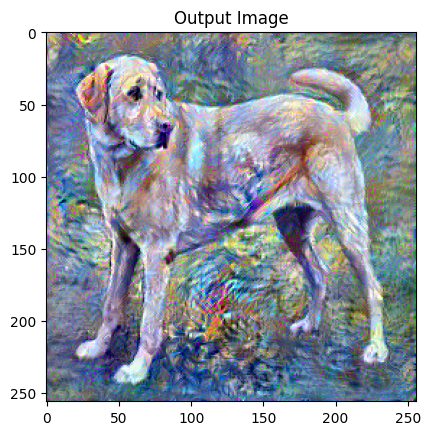

In [ ]:
plt.figure()
imshow(target_img.detach(), title='Output Image')
plt.show()